# Metaflow

Sometimes, we want to dream big! In this case, let's imagine we want to put all 4 examples ([preprocessing](example_preprocessing.ipynb), [1st-level](example_1stlevel.ipynb), [normalization](example_normalize.ipynb), [2nd-level](example_2ndlevel.ipynb)), into one big workflow, called **``metaflow``**. Like this, we would only need one script, to run a whole fMRI group analysis. **That's the power of Nipype!**

# Building the ``metaflow``

To build this ``metaflow``, we need to undertake the same steps as before.

## Imports
First things first, we need to import all interfaces and modules that we need.

In [ ]:
%pylab inline
from os.path import join as opj
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.algorithms.misc import Gunzip
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.afni import Resample
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.fsl import Info, MCFLIRT, FLIRT
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (Smooth, Normalize12, Level1Design, EstimateModel,
                                   EstimateContrast, OneSampleTTestDesign, Threshold)

Populating the interactive namespace from numpy and matplotlib


## Experiment parameters

As before, it's always a good idea to specify all experiment specific parameters at the beginning of your script.

In [ ]:
experiment_dir = '/output'
output_dir = 'datasink_metaflow'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05']

# list of session identifiers
session_list = ['run-1', 'run-2']

# Smoothing widths to apply
fwhm = [4, 8]

# TR of functional images
TR = 2

# Template to normalize to for ANTs
templateANTs = Info.standard_image('MNI152_T1_2mm.nii.gz')

# Template to normalize to for SPM
templateSPM = '/opt/spm12/spm12_mcr/spm12/tpm/TPM.nii'

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005',
                 'ess_0006', 'ess_0007']

# Mask to use for the group analysis
mask = Info.standard_image('MNI152_T1_2mm_brain_mask.nii.gz')

## Specify Nodes

Now, let's specify all nodes that we need.

### Nodes we need for preprocessing

It's **important** to notice, that we changed this section a bit from the one under [Example 1 Preprocessing](example_preprocessing.ipynb). Most of the preprocessing nodes were changed to ``MapNodes``. This is because, we need to run them on all session files, i.e. ``run-1`` and ``run-2``. This was also the case in example 1, but in the ``metaflwo`` we need the input for the ``modelspec`` node in the 1st-level anaylsis to be an array of files, i.e. ``['run-1.nii', 'run-2.nii']``. By sending the functional images of the preprocessing workflow through ``MapNodes`` we can make sure that arrive as an array list in the 1st-level Workflow.

In [ ]:
# MCFLIRT - motion correction
mcflirt = MapNode(MCFLIRT(mean_vol=True,
                          save_plots=True,
                          output_type='NIFTI'),
                  name="mcflirt", iterfield=['in_file'])

# Resample - resample anatomy to 3x3x3 voxel resolution
resample = Node(Resample(voxel_size=(3, 3, 3),
                         outputtype='NIFTI'),
                name="resample")

# FLIRT - coregister functional images to anatomical images
coreg_step1 = MapNode(FLIRT(output_type='NIFTI'),
                      name="coreg_step1", iterfield=['in_file'])
coreg_step2 = MapNode(FLIRT(output_type='NIFTI',
                            apply_xfm=True),
                      name="coreg_step2", iterfield=['in_file', 'in_matrix_file'])

# Smooth - image smoothing
smooth = MapNode(Smooth(), name="smooth", iterfield=['in_files'])
smooth.iterables = ("fwhm", fwhm)

### Nodes we need for the 1-st level analysis

In [ ]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

### Node we need for the normalization with ANTs

Don't forget to link to the right template.

In [ ]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='Linear',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=templateANTs,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

### Nodes we need for the normalization with SPM

Don't forget to link to the right template.

In [ ]:
# Gunzip - unzip the contrast image
gunzip = Node(Gunzip(), name="gunzip")

# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                            tpm=templateSPM,
                            write_voxel_sizes=[2, 2, 2]),
                 name="normalize")

### Nodes we need for the 2nd level analysis

Here we need to rename the ``gunzip`` node, as the same name was already used during SPM's normalization. Also, as we will use the all nodes twice, once for the SPM and once for the ANTs version, we need to duplicate them.

In [ ]:
# Gunzip - unzip the mask image
gunzip2A = Node(Gunzip(in_file=mask), name="gunzip2A")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdesA = Node(OneSampleTTestDesign(),
                          name="onesamplettestdesA")

# EstimateModel - estimates the model
level2estimateA = Node(EstimateModel(estimation_method={'Classical': 1}),
                       name="level2estimateA")

# EstimateContrast - estimates group contrast
level2conestimateA = Node(EstimateContrast(group_contrast=True),
                          name="level2conestimateA")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimateA.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2threshA = Node(Threshold(contrast_index=1,
                               use_topo_fdr=True,
                               use_fwe_correction=False,
                               extent_threshold=0,
                               height_threshold=0.005,
                               height_threshold_type='p-value',
                               extent_fdr_p_threshold=0.05),
                     name="level2threshA")

# Cloning of all nodes for the ANTs 2nd level analysis
gunzip2B = gunzip2A.clone('gunzip2B')
onesamplettestdesB = onesamplettestdesA.clone('onesamplettestdesB')
level2estimateB = level2estimateA.clone('level2estimateB')
level2conestimateB = level2conestimateA.clone('level2conestimateB')
level2threshB = level2threshA.clone('level2threshB')

## Specify GLM contrasts

In [ ]:
# Condition names
condition_names = ['congruent', 'incongruent']

# Contrasts
cont01 = ['average',        'T', condition_names, [0.5, 0.5]]
cont02 = ['congruent',      'T', condition_names, [1, 0]]
cont03 = ['incongruent',    'T', condition_names, [0, 1]]
cont04 = ['cong > incong', 'T', condition_names, [1, -1]]
cont05 = ['incong > cong', 'T', condition_names, [-1, 1]]

cont06 = ['activation',     'F', [cont02, cont03]]
cont07 = ['differences',    'F', [cont04, cont05]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07]

## Specify GLM Model

In [ ]:
def subjectinfo(subject_id):

    import numpy as np
    from os.path import join as opj
    from nipype.interfaces.base import Bunch

    condition_names = ['congruent', 'incongruent']
    
    logfile_dir = opj('/data', 'ds102', subject_id, 'func')

    for sess in ['run-1', 'run-2']:
        
        # Read the TSV file
        filename = opj(logfile_dir, '%s_task-flanker_%s_events.tsv' % (subject_id, sess))

        # Save relevant information
        trailinfo = np.genfromtxt(filename, delimiter='\t', dtype=None, skip_header=1)
        trailinfo = [[t[0], t[7]] for t in trailinfo]

        # Separate onset of conditions
        onset1 = []
        onset2 = []

        for t in trailinfo:
            if 'incongruent' in t[1]:
                onset2.append(t[0])
            else:
                onset1.append(t[0])

        # Svae values per session
        if sess == 'run-1':
            run1 = [onset1, onset2]
        elif sess == 'run-2':
            run2 = [onset1, onset2]

    subjectinfo = []
    for r in range(2):
        if r == 0:
            onsetTimes = run1
        elif r == 1:
            onsetTimes = run2

        subjectinfo.insert(r,
                           Bunch(conditions=condition_names,
                                 onsets=onsetTimes,
                                 durations=[[2.0], [2.0]],
                                 amplitudes=None,
                                 tmod=None,
                                 pmod=None,
                                 regressor_names=None,
                                 regressors=None))

    return subjectinfo  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

## Specify input & output stream

This is one of the more important parts of the ``metaflows``, as we can merge the ``IdentityInterface``, ``SelectFiles`` and ``Datasink`` nodes into one each. 

It's **important** to mention here, that some of the template files, such as ``mc_par`` from preprocessing or ``cons`` from normalization are not used as inputs for the ``selectfiles`` node. This is because we will link the different workflows directly to each other, later on. Also, ``func_file`` template now looks for files with ``{subject_id}_task-flanker_*_bold.nii.gz'`` instead of ``{subject_id}_task-flanker_{session_id}_bold.nii.gz'``. For an explanation why we do want that, see [this section](example_metaflow.ipynb#Nodes-we-need-for-preprocessing).

In [ ]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id', 'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('ds102', '{subject_id}', 'anat', '{subject_id}_T1w.nii.gz')
func_file = opj('ds102', '{subject_id}', 'func', '{subject_id}_task-flanker_*_bold.nii.gz')
transform = opj('antsdir', '{subject_id}', 'transformComposite.h5')

templates = {'anat': anat_file,
             'func': func_file,
             'transform': transform}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id', ''),
                 ('_task-flanker', ''),
                 ('_mcf.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('%s_%s/' % (sess, sub), '%s/%s' % (sub, sess))
               for sess in session_list for sub in subject_list]
subjFolders += [('%s_%s' % (sub, sess), '')
                 for sess in session_list for sub in subject_list]
subjFolders += [('%s%s_' % (sess, sub), '')
                 for sess in session_list for sub in subject_list]
subjFolders += [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
                for f in fwhm for sub in subject_list]
subjFolders += [('_apply2con%s/' % (i), '') for i in range(7)]
subjFolders += [('%s_fwhm_id_%s' % (con, f), 'spm_%s_fwhm%s' % (con, f))
                for f in fwhm for con in contrast_list]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'ants_%s_fwhm%s' % (con, f))
                for f in fwhm for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflows

As before, we will define the different workflows from the example. The only difference for now is that we won't connect the input and output nodes within the workflows. We will establish the needed connections, but at a later stage, while creating the ``metaflow``.

### Create Preprocessing Workflow

In [ ]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(mcflirt, coreg_step1, [('mean_img', 'in_file')]),
                 (resample, coreg_step1, [('out_file', 'reference')]),
                 
                 (mcflirt, coreg_step2, [('out_file', 'in_file')]),
                 (resample, coreg_step2, [('out_file', 'reference')]),
                 (coreg_step1, coreg_step2, [('out_matrix_file', 'in_matrix_file')]),
                 
                 (coreg_step2, smooth, [('out_file', 'in_files')]),
                 ])

### Create 1st-level Workflow

In [ ]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(getsubjectinfo, modelspec, [('subject_info', 'subject_info')]),
                    (modelspec, level1design, [('session_info', 'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file', 'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file', 'spm_mat_file'),
                                                    ('beta_images', 'beta_images'),
                                                    ('residual_image', 'residual_image')]),
                    ])

### Create the two normalization Workflows

In [ ]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(gunzip, normalize, [('out_file', 'image_to_align')])])

In [ ]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.add_nodes([apply2con])

You might have realized that the ``antsflow`` from example 3, takes only inputs directly from the ``selectfiles`` node. As the ``selectfiles`` node of this workflow will be added to the ``metaflow``, we will not establish any connections here. But we can nonetheless already add the ``apply2con`` node to the ``antsflow``.

### Create 2nd-level Workflow

Here we shouldn't forget that we renamed the ``gunzip`` node to ``gunzip2``. Also, we have two 2nd-level workflows, one for the SPM normalized and one for the ANTs normalized output. Therefore, we need to rename those two workflows accordingly.

In [ ]:
# Initiation of the 2nd-level analysis workflow (SPM)
l2analysisSPM = Workflow(name='l2analysisSPM')
l2analysisSPM.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysisSPM.connect([(gunzip2A, onesamplettestdesA, [('out_file', 'explicit_mask_file')]),
                       (onesamplettestdesA, level2estimateA, [('spm_mat_file', 'spm_mat_file')]),
                       (level2estimateA, level2conestimateA, [('spm_mat_file', 'spm_mat_file'),
                                                              ('beta_images', 'beta_images'),
                                                              ('residual_image', 'residual_image')]),
                       (level2conestimateA, level2threshA, [('spm_mat_file', 'spm_mat_file'),
                                                            ('spmT_images', 'stat_image'),
                                                            ]),
                       ])

In [ ]:
# Initiation of the 2nd-level analysis workflow (ANTs)
l2analysisANTs = Workflow(name='l2analysisANTs')
l2analysisANTs.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysisANTs.connect([(gunzip2B, onesamplettestdesB, [('out_file', 'explicit_mask_file')]),
                        (onesamplettestdesB, level2estimateB, [('spm_mat_file', 'spm_mat_file')]),
                        (level2estimateB, level2conestimateB, [('spm_mat_file', 'spm_mat_file'),
                                                               ('beta_images', 'beta_images'),
                                                               ('residual_image', 'residual_image')]),
                        (level2conestimateB, level2threshB, [('spm_mat_file', 'spm_mat_file'),
                                                             ('spmT_images', 'stat_image'),
                                                             ]),
                        ])

## Building the ``metaflow`` (NEW)

This is a new step, as we now connect workflows to each other, and not just to nodes.

### First step, create the meta workflow.

In [ ]:
metaflow = Workflow(name='metaflow')
metaflow.base_dir = opj(experiment_dir, working_dir)

### Second step, connect the workflows to each other

You will notice that connecting workflows to each other is similar to connecting nodes, but not exactly. For once, you have to specify which workflows you want to connect, and than also which nodes the input and output fields are belonging to.

In [ ]:
metaflow.connect([(preproc, l1analysis, [('smooth.smoothed_files', 'modelspec.functional_runs'),
                                         ('mcflirt.par_file', 'modelspec.realignment_parameters'),
                                         ]),
                  (l1analysis, spmflow, [('level1conest.con_images', 'normalize.apply_to_files')]),
                  (l1analysis, antsflow, [('level1conest.con_images', 'apply2con.input_image')]),
                  (spmflow, l2analysisSPM, [('normalize.normalized_files', 'onesamplettestdesA.in_files')]),
                  (antsflow, l2analysisANTs, [('apply2con.output_image', 'onesamplettestdesB.in_files')]),
                  ])

### Third step, connecting the input & output stream to the ``metaflow``

In [ ]:
metaflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('fwhm_id', 'fwhm_id')
                                             ]),
                  (selectfiles, preproc, [('func', 'mcflirt.in_file'),
                                         ('anat', 'resample.in_file')]),
                  (infosource, l1analysis, [('subject_id', 'getsubjectinfo.subject_id'),
                                            ('contrasts', 'level1conest.contrasts')]),
                  (selectfiles, spmflow, [('anat', 'gunzip.in_file')]),
                  (selectfiles, antsflow, [('transform', 'apply2con.transforms')]),

                  (preproc, datasink, [('mcflirt.par_file', 'preproc.@par'),
                                       ('resample.out_file', 'preproc.@resample'),
                                       ('coreg_step1.out_file', 'preproc.@coregmean'),
                                       ('smooth.smoothed_files', 'preproc.@smooth'),
                                       ]),
                  (l1analysis, datasink, [('level1conest.spm_mat_file', '1stLevel.@spm_mat'),
                                          ('level1conest.spmT_images', '1stLevel.@T'),
                                          ('level1conest.con_images', '1stLevel.@con'),
                                          ('level1conest.spmF_images', '1stLevel.@F'),
                                          ('level1conest.ess_images', '1stLevel.@ess'),
                                          ]),
                  (spmflow, datasink, [('normalize.normalized_files', 'norm_spm.@files'),
                                       ('normalize.normalized_image', 'norm_spm.@image')]),
                  (antsflow, datasink, [('apply2con.output_image', 'norm_ants.@con')]),
                  (l2analysisSPM, datasink, [('level2conestimateA.spm_mat_file', '2ndLevelSPM.@spm_mat'),
                                             ('level2conestimateA.spmT_images', '2ndLevelSPM.@T'),
                                             ('level2conestimateA.con_images', '2ndLevelSPM.@con'),
                                             ('level2threshA.thresholded_map', '2ndLevelSPM.@threshold'),
                                             ]),
                  (l2analysisANTs, datasink, [('level2conestimateB.spm_mat_file', '2ndLevelANTs.@spm_mat'),
                                             ('level2conestimateB.spmT_images', '2ndLevelANTs.@T'),
                                             ('level2conestimateB.con_images', '2ndLevelANTs.@con'),
                                             ('level2threshB.thresholded_map', '2ndLevelANTs.@threshold'),
                                             ]),
                  ])

## Visualize the workflow

170302-19:37:38,634 workflow INFO:
	 Converting dotfile: /output/workingdir/metaflow/graph.dot to png format


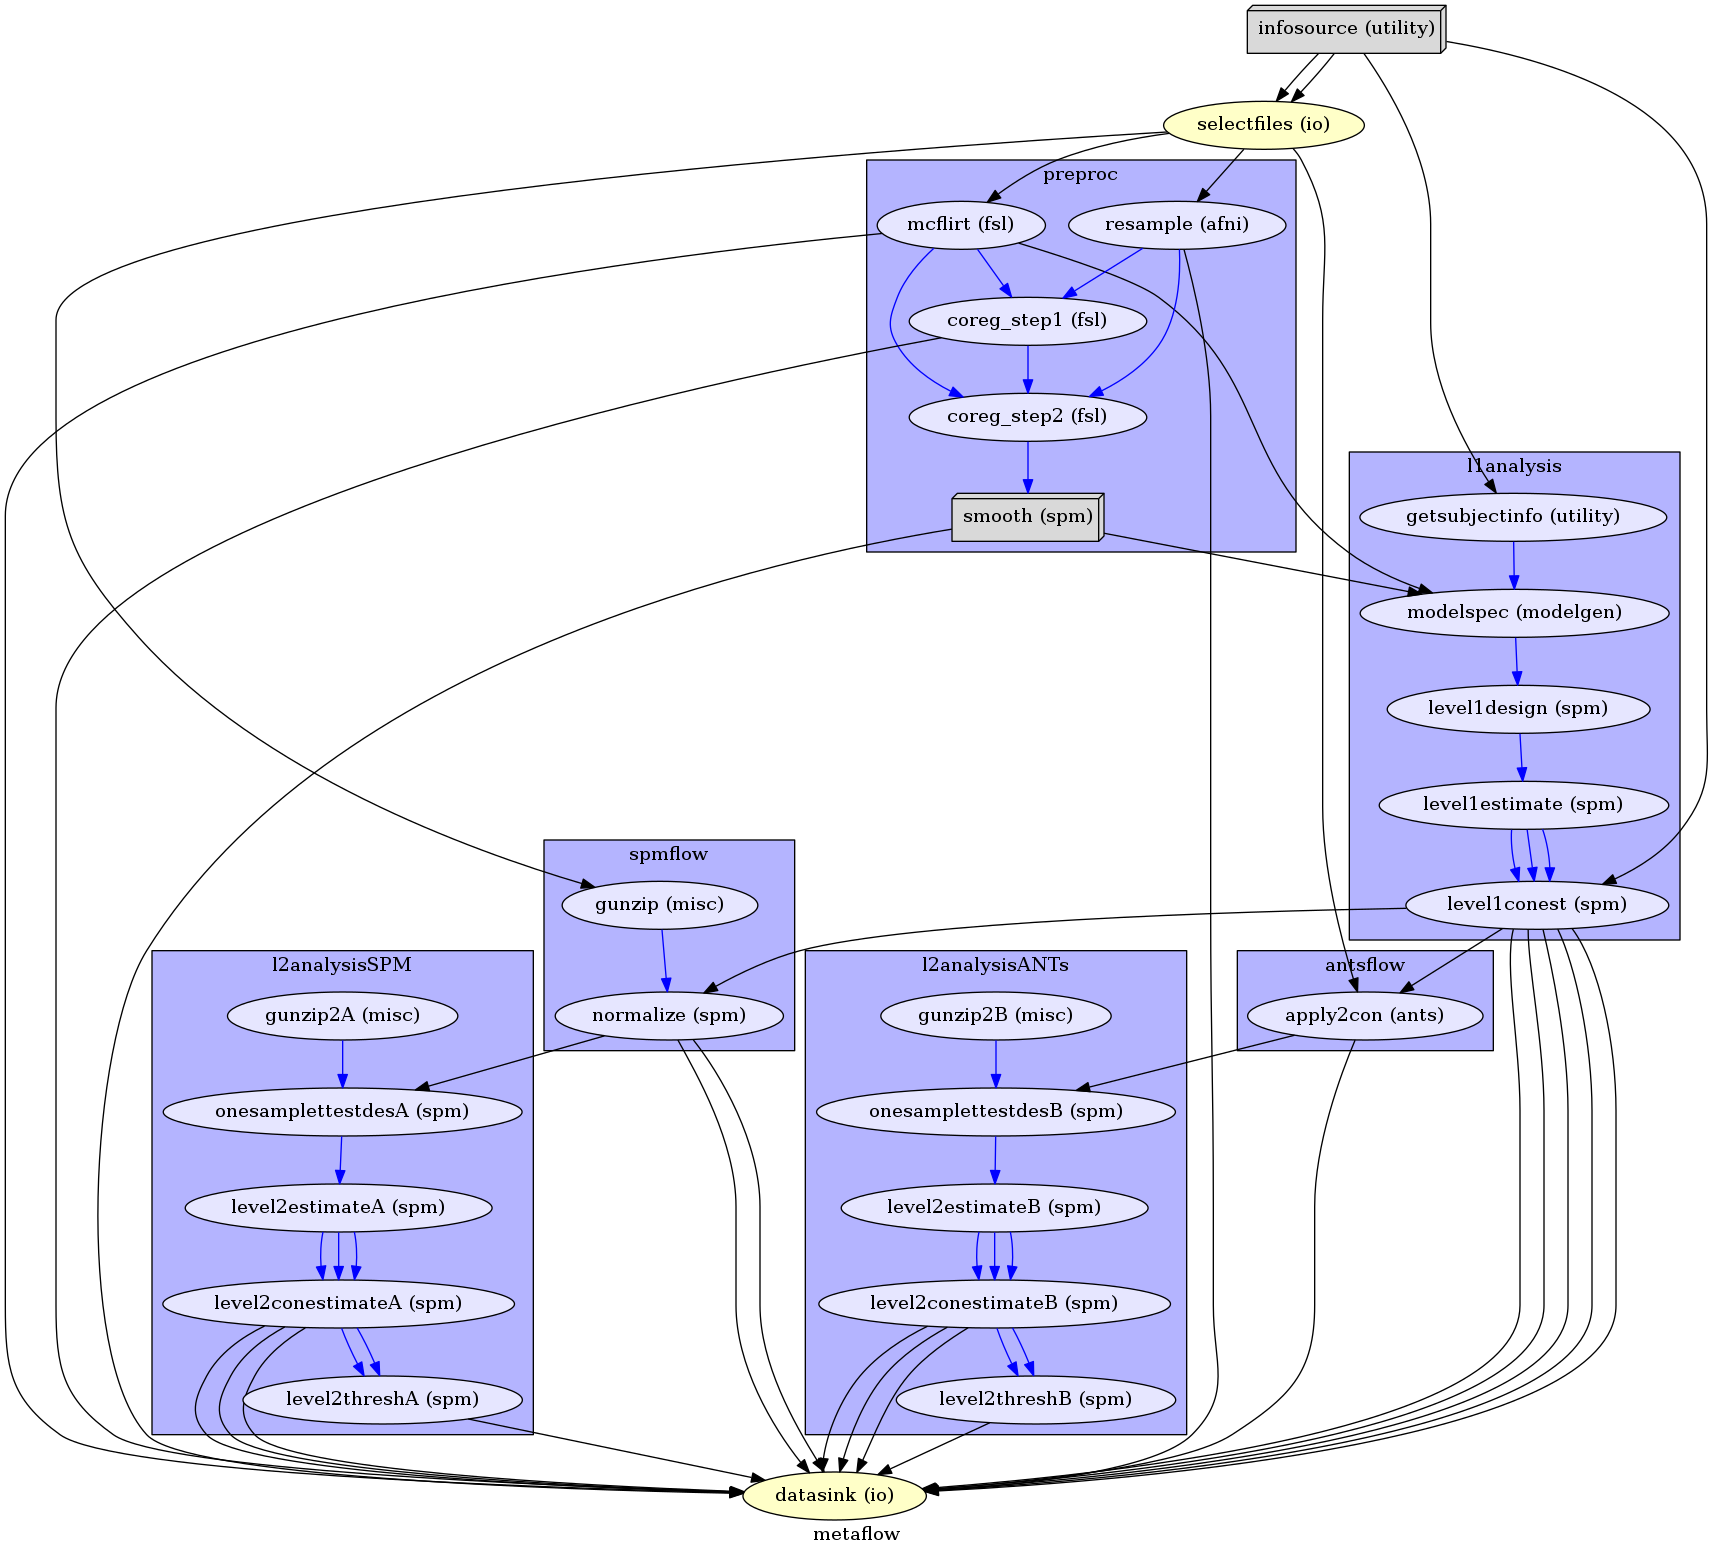

In [ ]:
# Create preproc output graph
metaflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(metaflow.base_dir, 'metaflow', 'graph.dot.png'))

170302-19:37:40,365 workflow INFO:
	 Creating detailed dot file: /output/workingdir/metaflow/graph_detailed.dot
170302-19:37:41,891 workflow INFO:
	 Creating dot file: /output/workingdir/metaflow/graph.dot


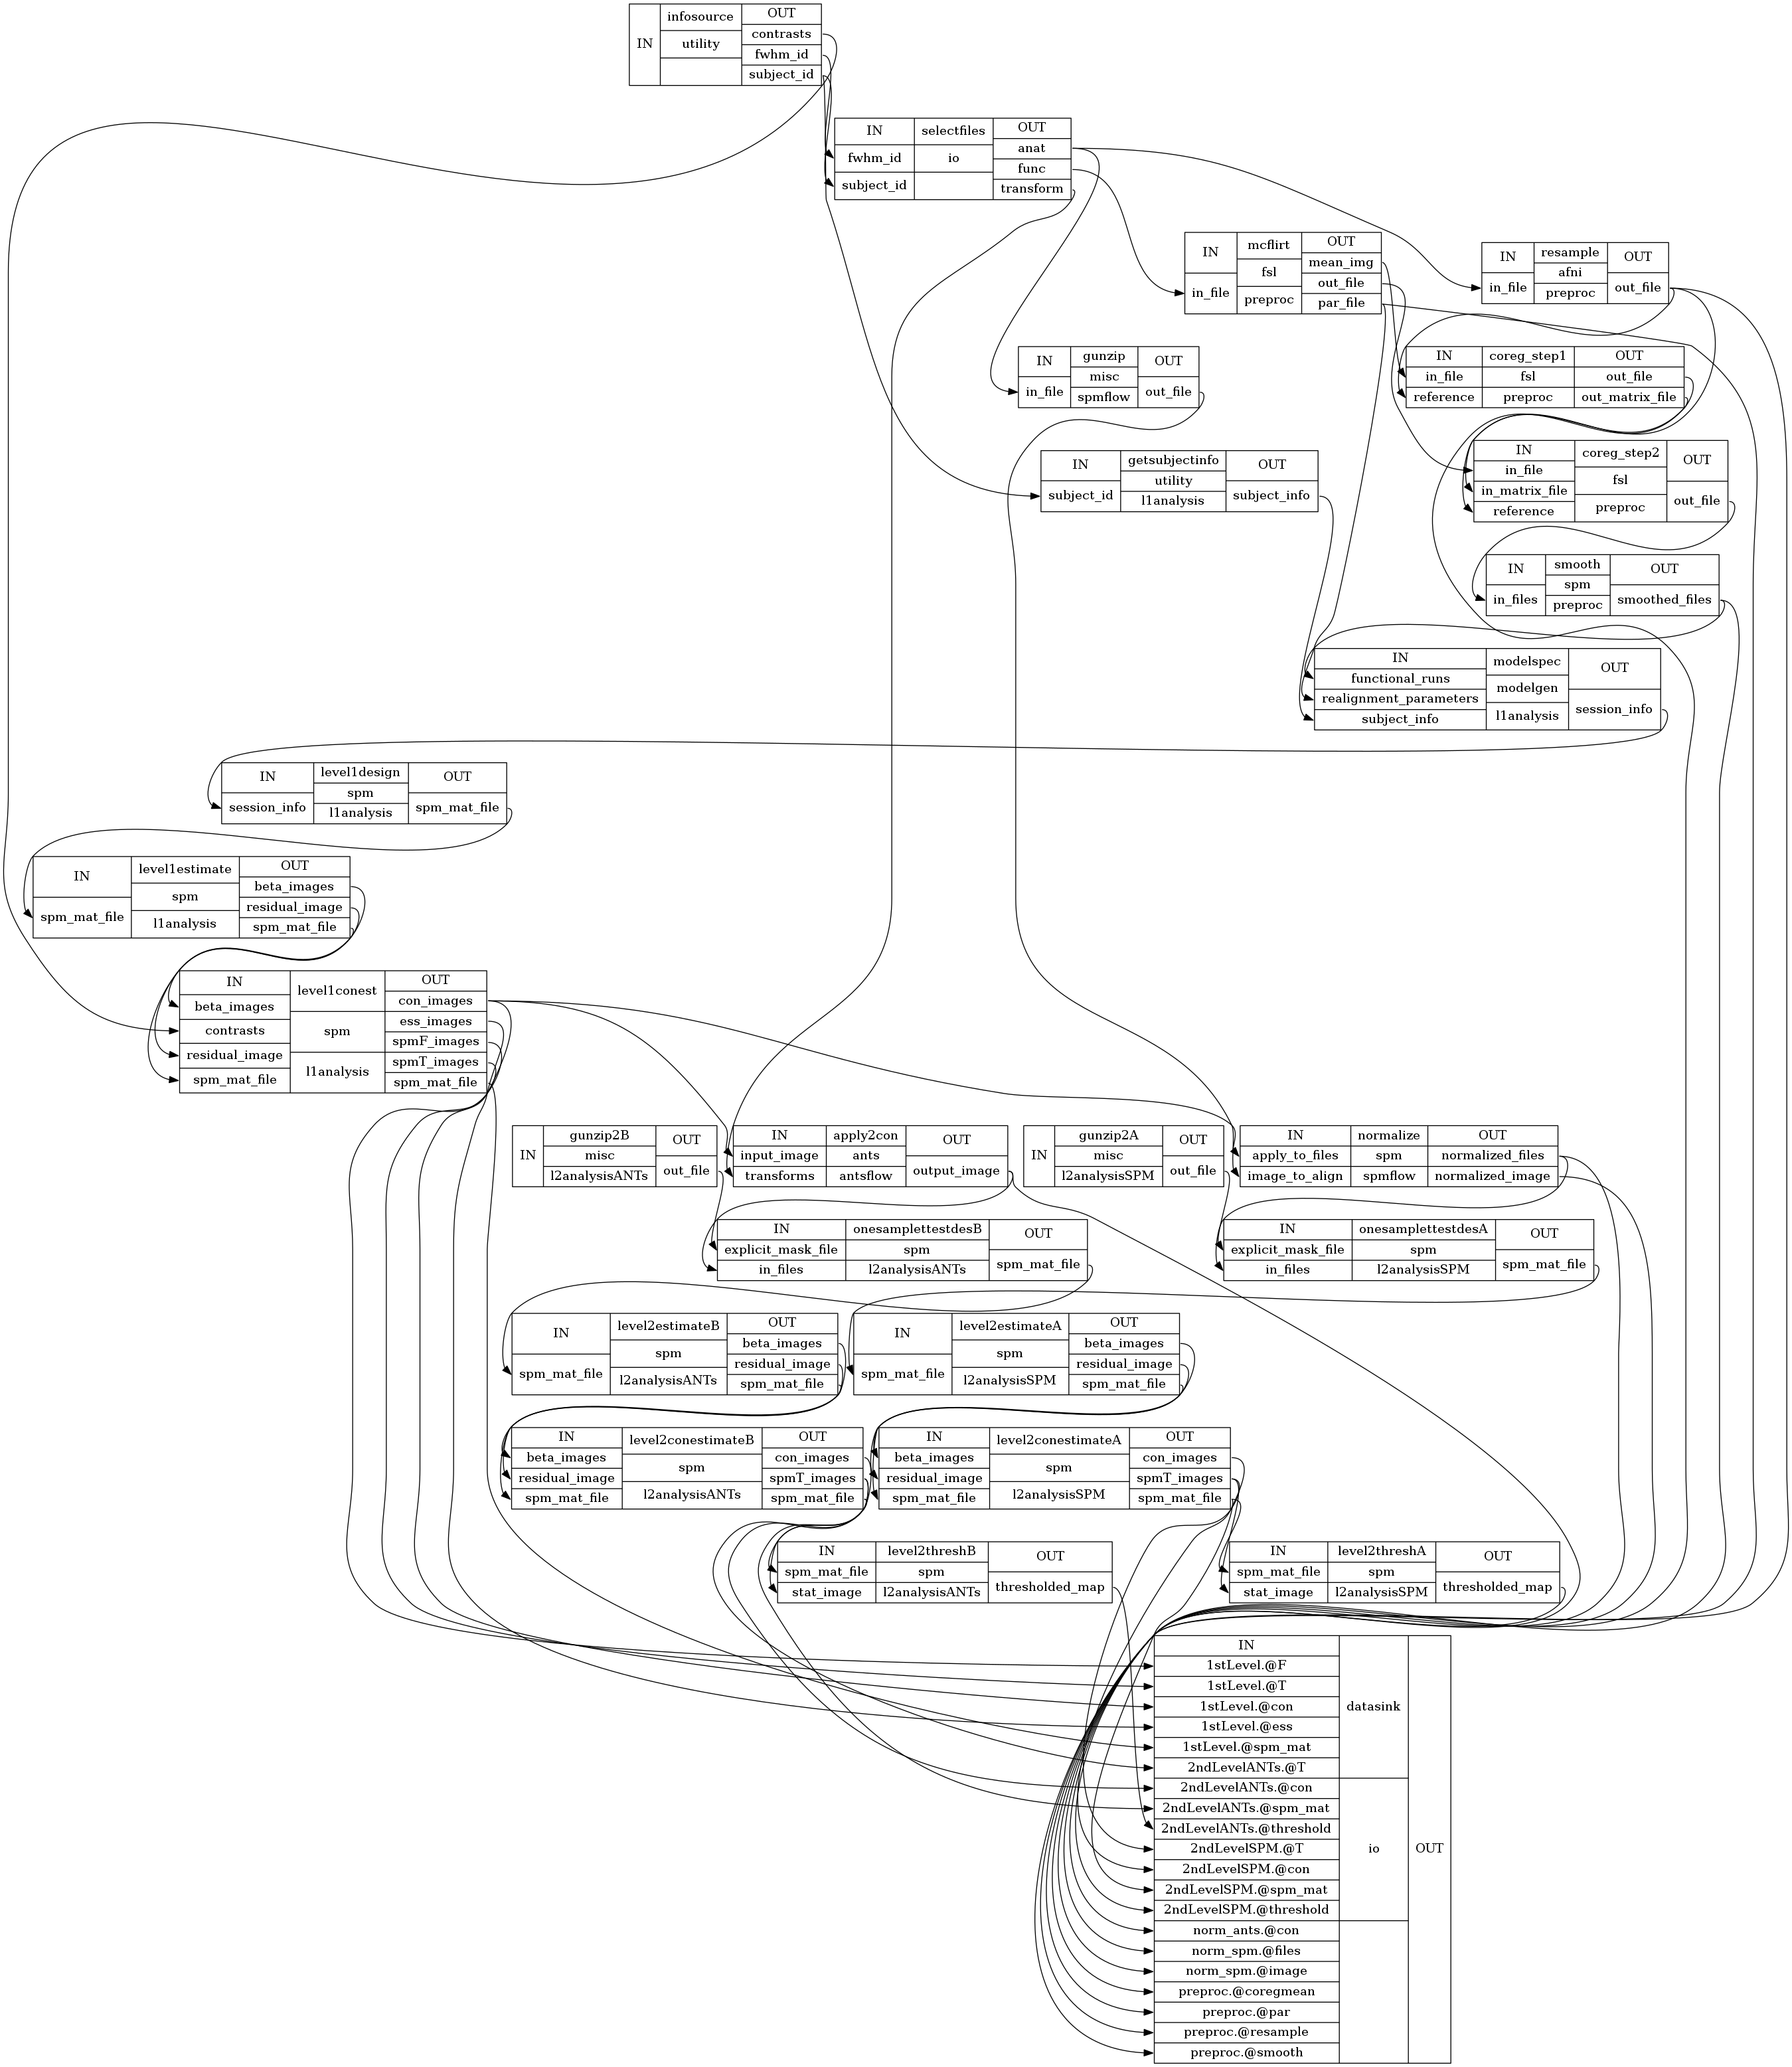

In [ ]:
# Visualize the detailed graph
metaflow.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(metaflow.base_dir, 'metaflow', 'graph_detailed.dot.png'))

##  Run the Workflow

In [ ]:
metaflow.run('MultiProc', plugin_args={'n_procs': 12})